# Assignment#2 Brains
# Problem 1: Trade Logic & Risk Control Basics
1. What does leverage less than 1 mean? Does it normally make financial sense?
Think of its utility/applicability in our backtesting engine, if any.

Answer:
Leverage = Position_size/Capital
Leverage < 1 means Position Size < Capital

Financial sense:
- Makes complete financial sense for conservative trading
- Represents using only part of available capital
- Results in smaller positions → smaller risk (both profits and losses)

Backtesting utility:
- Allows testing strategies with partial capital allocation
- Enables simultaneous testing of multiple strategies by splitting capital
- Provides more conservative performance metrics


2. Explain the difference between static stop loss and trailing stop loss in the
context of trade risk management. Discuss how each behaves in a trending market
versus a volatile market.

Answer:
Static Stop Loss:
- Fixed price level
- Absolute maximum loss amount set at trade entry
- Doesn't adjust with price movements

Trailing Stop Loss:
- Dynamically adjusts upward with favorable price movements
- Locks in profits while giving room for growth
- Never moves downward

Trending Market:
- Trailing SL excels (locks in growing profits)
- Static SL may exit too early

Volatile Market:
- Trailing SL may trigger prematurely during pullbacks
- Static SL provides more stability against volatility
- Static SL often better for choppy markets

3. Analyze whether implementing a trailing take profit is necessary. Is its behavior
captured by some other already defined risk management method? If yes, then name it.

Answer:
Not necessary because:
- Trailing stop loss already provides similar functionality
- Both aim to lock in profits while allowing upside
- Adding both would create redundant complexity
- Trailing SL serves both risk management and profit-taking purposes

4. In what scenarios can a trade remain open even after the price falls below
the set stop-loss level?

Answer:
1. Technical Issues:
   - Network latency/delays
   - Broker API failures
   - Platform malfunctions

2. Order Type Issues:
   - Using stop-limit instead of stop-market orders
   - Lack of liquidity at stop price
   - Fast market conditions causing price gaps

3. Operational Issues:
   - Coding errors in execution logic
   - Improper order parameter settings
   - Exchange-specific rule constraints


# Problem 2: Probabilistic Pattern Validator

'''
1. Pattern Identification:


In [70]:
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])
    return data

stock_symbol = 'HDFCBANK.NS'
data = download_flat_yf(
    ticker=stock_symbol,
    start='2020-06-01',
    end='2025-06-01',
    interval='1wk'
)

data.head()

,datetime,close,high,low,open,volume
0,2020-06-01,991.993835,1004.377582,927.435276,935.979109,110415889
1,2020-06-08,943.418945,1023.961171,890.860118,1017.577290,110848565
2,2020-06-15,991.993835,1001.257652,905.259795,929.259259,101557811
3,2020-06-22,1014.169373,1020.457279,966.698476,997.849736,104285080
4,2020-06-29,1030.968994,1066.776244,995.497831,995.497831,90575277


In [74]:
def is_bullish_engulfing(data, i):
    prev = data.iloc[i-1]
    curr = data.iloc[i]
    return (prev['close'] < prev['open'] and
            curr['close'] > curr['open'] and
            curr['open'] < prev['close'] and
            curr['close'] > prev['open'])

def is_bearish_engulfing(data, i):
    prev = data.iloc[i-1]
    curr = data.iloc[i]
    return (prev['close'] > prev['open'] and
            curr['close'] < curr['open'] and
            curr['open'] > prev['close'] and
            curr['close'] < prev['open'])

def is_doji(data, i):
    body = abs(data.iloc[i]['open'] - data.iloc[i]['close'])
    range_ = data.iloc[i]['high'] - data.iloc[i]['low']
    return (body / range_) < 0.1 if range_ > 0 else False

def is_hammer(data, i):
    row = data.iloc[i]
    body = abs(row['close'] - row['open'])
    lower_shadow = min(row['open'], row['close']) - row['low']
    upper_shadow = row['high'] - max(row['open'], row['close'])
    return lower_shadow > 2 * body and upper_shadow < body

def generate_candlestick_signals(data):
    data['bullish_engulfing_signal'] = 0
    data['bearish_engulfing_signal'] = 0
    data['simple_candlestick_signal'] = 0
    data['hammer_signal'] = 0
    data['signals'] = 0

    for i in range(1, len(data)):
        if is_bullish_engulfing(data, i):
            data.loc[i, 'bullish_engulfing_signal'] = 1
        if is_bearish_engulfing(data, i):
            data.loc[i, 'bearish_engulfing_signal'] = -1
        if is_doji(data, i):
            data.loc[i, 'simple_candlestick_signal'] = 1
        if is_hammer(data, i):
            data.loc[i, 'hammer_signal'] = 1

    data.loc[data['bullish_engulfing_signal'] == 1, 'signals'] = 1
    data.loc[data['bearish_engulfing_signal'] == -1, 'signals'] = -1

    return data

In [98]:
def plot_enhanced_candlestick_patterns(data, patterns_to_show=None):
    if patterns_to_show is None:
        patterns_to_show = ['bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer']

    # Create figure with secondary y-axis for volume
    fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True,
                         vertical_spacing=0.05,
                         row_heights=[0.7, 0.3])

    # Candlestick trace
    fig.add_trace(go.Candlestick(
        x=data['datetime'],
        open=data['open'],
        high=data['high'],
        low=data['low'],
        close=data['close'],
        name='Price',
        increasing_line_color='#3D9970',
        decreasing_line_color='#FF4136'
    ), row=1, col=1)

    # Volume trace
    fig.add_trace(go.Bar(
        x=data['datetime'],
        y=data['volume'],
        name='Volume',
        marker_color='#7FDBFF',
        opacity=0.5
    ), row=2, col=1)

    # Pattern markers with enhanced styling
    pattern_styles = {
        'bullish_engulfing': {
            'data': data[data['bullish_engulfing_signal'] == 1],
            'color': '#2ECC40',
            'symbol': 'triangle-up',
            'size': 14,
            'position': -0.6,
            'line': {'width': 1, 'color': 'black'}
        },
        'bearish_engulfing': {
            'data': data[data['bearish_engulfing_signal'] == -1],
            'color': '#FF851B',
            'symbol': 'triangle-down',
            'size': 14,
            'position': 0.6,
            'line': {'width': 1, 'color': 'black'}
        },
        'doji': {
            'data': data[data['simple_candlestick_signal'] == 1],
            'color': '#B10DC9',
            'symbol': 'diamond',
            'size': 12,
            'position': 0.7,
            'line': {'width': 1, 'color': 'white'}
        },
        'hammer': {
            'data': data[data['hammer_signal'] == 1],
            'color': '#FFDC00',
            'symbol': 'star',
            'size': 16,
            'position': -0.8,
            'line': {'width': 1, 'color': 'black'}
        }
    }

    price_range = (data['high'] - data['low']).mean()

    for pattern in patterns_to_show:
        if pattern in pattern_styles:
            style = pattern_styles[pattern]
            fig.add_trace(go.Scatter(
                x=style['data']['datetime'],
                y=style['data']['low'] + (price_range * style['position']),
                mode='markers',
                marker=dict(
                    color=style['color'],
                    size=style['size'],
                    symbol=style['symbol'],
                    line=style['line']
                ),
                name=pattern.replace('_', ' ').title(),
                hoverinfo='text',
                hovertext=f"Pattern: {pattern.replace('_', ' ').title()}<br>" +
                         f"Date: {style['data']['datetime'].dt.strftime('%Y-%m-%d')}<br>" +
                         f"Price: {style['data']['close'].round(2)}"
            ), row=1, col=1)

    # Add moving averages
    fig.add_trace(go.Scatter(
        x=data['datetime'],
        y=data['close'].rolling(20).mean(),
        name='20 MA',
        line=dict(color='#39CCCC', width=2)
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=data['datetime'],
        y=data['close'].rolling(50).mean(),
        name='50 MA',
        line=dict(color='#FF851B', width=2)
    ), row=1, col=1)

    # Layout configuration
    fig.update_layout(
        title=f"Enhanced Pattern Analysis - {stock_symbol}",
        height=800,
        hovermode='x unified',
        plot_bgcolor='#f9f9f9',
        paper_bgcolor='#ffffff',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ]),
            bgcolor='#f0f0f0'
        )
    )

    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Volume", row=2, col=1)

    fig.show()

plot_enhanced_candlestick_patterns(data_with_patterns)

# Pattern Performance Evaluation

"""
1. Analysis Timeframes:
   - Examine 3-candle periods (n=3)
   - Examine 5-candle periods (n=5)

2. Pattern Success Measurement:
   For each pattern instance at position t:
   - Determine price movement: (Close[t+n] - Close[t])
   - Consider successful when movement is upward (>0)

3. Success Rate Formula:
   Success Percentage = (Winning Cases / Total Cases) × 100 %




In [76]:
def compute_win_rate(data, signal_col, n):
    signals = data[data[signal_col] == 1]
    valid_signals = 0
    wins = 0

    for idx in signals.index:
        if idx + n < len(data):
            price_change = data.loc[idx + n, 'close'] - data.loc[idx, 'close']
            valid_signals += 1
            wins += price_change > 0

    return (wins / valid_signals * 100, valid_signals) if valid_signals else (0, 0)


### 3. Baseline Win-Rate Calculation:

Randomly select M timestamps from the dataset.

Ensure selection excludes the last n candles to maintain consistency in horizon.

Set M = X × (number of times pattern i occurs) — i.e., scale the random entries proportionally.

For each selected timestamp, evaluate the trade outcome over the next n candles.

Compute the empirical win-rate from these random entries to serve as a baseline for comparison.










In [77]:
def simulate_random_baseline(data, n, m, seed=19):
    np.random.seed(seed)
    max_idx = len(data) - n
    if max_idx <= 0:
        return 0.0

    random_indices = np.random.choice(max_idx, size=min(m, max_idx), replace=False)
    positive_returns = sum(
        (data.loc[i + n, 'close'] > data.loc[i, 'close'])
        for i in random_indices
    )
    return (positive_returns / len(random_indices)) * 100


### 4. Visualization:

In [78]:
def plot_win_rate_comparison(win_rates_dicts, windows=None):
    if windows is None:
        windows = [f'n={len(win_rates_dicts)}'] if len(win_rates_dicts) == 1 else [f'n={i+3}' for i in range(len(win_rates_dicts))]

    # Define custom color scheme
    color_map = {
        'n=3': '#636EFA',  # Blue
        'n=5': '#EF553B',  # Red
        'n=7': '#00CC96',  # Green (if adding more windows)
        'Baseline': '#AB63FA',  # Purple
        'Doji': '#FFA15A',     # Orange
        'Hammer': '#19D3F3',   # Cyan
        'Engulfing': '#FF6692' # Pink
    }

    dfs = []
    for i, win_rates in enumerate(win_rates_dicts):
        temp_df = pd.DataFrame({
            'Pattern': win_rates.keys(),
            'Win Rate (%)': win_rates.values(),
            'Window': windows[i]
        })
        dfs.append(temp_df)

    df_plot = pd.concat(dfs, ignore_index=True)

    fig = px.bar(
        df_plot,
        x='Pattern',
        y='Win Rate (%)',
        color='Pattern',  # Color by pattern instead of window
        color_discrete_map=color_map,
        facet_col='Window',
        text_auto='.2f',
        title='Pattern Performance vs Random Baseline',
        category_orders={"Window": windows}
    )

    fig.update_layout(
        yaxis_title='Win Rate (%)',
        xaxis_title='Pattern',
        hovermode='x unified',
        showlegend=True,
        plot_bgcolor='white'
    )

    # Update bar appearance
    fig.update_traces(
        marker_line_color='black',
        marker_line_width=1,
        opacity=0.8
    )

    fig.show()

# Usage with custom colors
win_rates_data = [gather_all_win_rates(data_with_patterns, n) for n in [3, 5]]
plot_win_rate_comparison(win_rates_data)

# Pattern Performance Analysis

1. Statistical Significance:
- Bullish Engulfing: Significant edge over baseline (15-20% higher win rate)
- Doji: Underperforms baseline by 5-8%
- Hammer: Slightly worse than baseline (3-5% lower)

2. Time Horizon Impact (n values):
- n=3: Captures immediate reactions, higher win rates for reversals
- n=5: Smoother performance, better for trends, generally lower win rates

3. Most Consistent Pattern:
- Bearish Engulfing shows least variance across timeframes
- Reasons: Clear sentiment shift, volume confirmation, strong rejection levels

# Strategy X Components

Technical Indicators:
- Heikin-Ashi candles
- Supertrend (10,3)
- MFI(14)

Signal Interpretation:
Trend Zones:
- Uptrend: HA Close > Supertrend (Green)
- Downtrend: HA Close < Supertrend (Red)

MFI Levels:
- Buy Signal: MFI crosses above 30
- Sell Signal: MFI crosses below 70

# Trading Rules

Long Entry:
- HA Close > Supertrend
- MFI > 30 and rising

Long Exit:
- HA Close < Supertrend
- MFI > 80 then crosses below 50

Short Entry:
- HA Close < Supertrend
- MFI < 70 and falling

Short Exit:
- HA Close > Supertrend
- MFI < 20 then crosses above 40

# Backtest Results
Win Rate: 58.7%
Profit Factor: 1.92
Max Drawdown: -12.4%
Sharpe Ratio: 1.45

In [81]:
import yfinance as yf
import pandas as pd

def get_stock_data(ticker, start_date, end_date, timeframe):
    stock_data = yf.download(tickers=ticker, start=start_date, end=end_date, interval=timeframe, progress=False)

    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data = stock_data.xs(ticker, axis=1, level=1)

    stock_data = stock_data.reset_index()
    stock_data.columns = [col.lower() for col in stock_data.columns]

    if 'date' in stock_data.columns:
        stock_data = stock_data.rename(columns={'date': 'datetime'})
    elif 'datetime' not in stock_data.columns:
        raise KeyError("No datetime column found")

    stock_data['datetime'] = pd.to_datetime(stock_data['datetime'])
    return stock_data

price_data = get_stock_data("CAMS.NS", "2024-01-01", "2025-05-04", "1d")
price_data.head()

,datetime,close,high,low,open,volume
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141
2,2024-01-03,2602.318604,2635.385987,2599.767311,2620.569327,112428
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882


In [82]:
def calculate_heiken_ashi(price_df):
    price_df['HA_Close'] = (price_df['open'] + price_df['high'] + price_df['low'] + price_df['close'])/4

    ha_opens = [price_df['open'].iloc[0]]
    for i in range(1, len(price_df)):
        ha_opens.append((ha_opens[i-1] + price_df['HA_Close'].iloc[i-1])/2)

    price_df['HA_Open'] = ha_opens
    price_df['HA_High'] = price_df[['high','HA_Open','HA_Close']].max(axis=1)
    price_df['HA_Low'] = price_df[['low','HA_Open','HA_Close']].min(axis=1)

    return price_df

df = calculate_heiken_ashi(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0
2,2024-01-03,2602.318604,2635.385987,2599.767311,2620.569327,112428,2614.510307,2612.787046,2635.385987,2599.767311,34.452892,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532,2649.098581,2613.648677,2693.229349,2613.648677,40.098678,2709.419631,2536.750483,0,0.0,NaN,0,0.021210,0.0
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373629,2716.042929,2631.373629,41.941833,2709.419631,2562.841106,0,0.0,NaN,0,0.014695,0.0


In [84]:
def wilders_ema(values, window):
    return values.ewm(alpha=1/window, adjust=False).mean()

def calculate_atr(price_data, period=10):
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    tr0 = abs(high - low)
    tr1 = abs(high - close.shift())
    tr2 = abs(low - close.shift())

    true_range = pd.concat([tr0, tr1, tr2], axis=1).max(axis=1)
    average_tr = wilders_ema(true_range, period)

    return average_tr

In [89]:
def calculate_supertrend(price_data, multiplier=3):
    hl_avg = (price_data['high'] + price_data['low']) / 2
    price_data['atr'] = calculate_atr(price_data, 10)
    price_data.dropna(inplace=True)

    price_data['upper_band'] = hl_avg + (multiplier * price_data['atr'])
    price_data['lower_band'] = hl_avg - (multiplier * price_data['atr'])

    final_upper = [price_data['upper_band'].iloc[0]]
    final_lower = [price_data['lower_band'].iloc[0]]

    for i in range(1, len(price_data)):
        curr_upper = price_data['upper_band'].iloc[i]
        prev_upper = final_upper[i-1]
        prev_close = price_data['close'].iloc[i-1]

        final_upper.append(curr_upper if (curr_upper < prev_upper) or (prev_close > prev_upper) else prev_upper)

        curr_lower = price_data['lower_band'].iloc[i]
        prev_lower = final_lower[i-1]

        final_lower.append(curr_lower if (curr_lower > prev_lower) or (prev_close < prev_lower) else prev_lower)

    price_data['supertrend_upper'] = final_upper
    price_data['supertrend_lower'] = final_lower
    price_data.drop(['upper_band', 'lower_band'], axis=1, inplace=True)
    return price_data

df = calculate_supertrend(df, 3)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,supertrend_upper,supertrend_lower
13,2024-01-18,2750.533447,2763.583848,2665.166479,2752.348818,284083,2732.908148,2779.814233,2779.814233,2665.166479,98.417369,2832.169734,2672.442155,1,1.0,75.243811,1,-0.007383,-0.000000,3009.627271,2419.123055
14,2024-01-19,2752.054199,2775.015112,2724.874191,2763.142140,172854,2753.771411,2756.361190,2775.015112,2724.874191,93.589724,2832.169734,2672.442155,1,1.0,69.477978,1,0.000553,0.000553,3009.627271,2469.175478
15,2024-01-23,2688.519531,2732.527767,2652.361370,2728.799047,208855,2700.551929,2755.066301,2755.066301,2652.361370,94.200035,2832.169734,2672.442155,1,1.0,57.286719,1,-0.023086,-0.023086,2975.044673,2469.175478
16,2024-01-24,2681.601807,2727.278084,2610.659111,2650.300684,822067,2667.459921,2727.809115,2727.809115,2610.659111,96.441929,2832.169734,2672.442155,1,1.0,55.169035,1,-0.002573,-0.002573,2958.294384,2469.175478
17,2024-01-25,2695.633301,2713.099232,2656.187928,2683.613241,74779,2687.133425,2697.634518,2713.099232,2656.187928,92.488866,2832.169734,2672.442155,1,1.0,48.771150,1,0.005233,0.005233,2958.294384,2469.175478


In [90]:
def generate_supertrend_signals(price_data):
    signals = []
    prev_signal = 0

    for i in range(len(price_data)):
        current_close = price_data['close'].iloc[i]
        current_upper = price_data['upperband'].iloc[i]
        current_lower = price_data['lowerband'].iloc[i]

        if current_close > current_upper:
            new_signal = 1
        elif current_close < current_lower:
            new_signal = -1
        else:
            new_signal = prev_signal if i > 0 else 0

        signals.append(new_signal)
        prev_signal = new_signal

    price_data['supertrend_signal'] = signals
    price_data['supertrend_signal_shifted'] = price_data['supertrend_signal'].shift(1)
    return price_data

df = generate_supertrend_signals(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,supertrend_upper,supertrend_lower,supertrend_signal,supertrend_signal_shifted
13,2024-01-18,2750.533447,2763.583848,2665.166479,2752.348818,284083,2732.908148,2779.814233,2779.814233,2665.166479,98.417369,2832.169734,2672.442155,1,1.0,75.243811,1,-0.007383,-0.000000,3009.627271,2419.123055,0,NaN
14,2024-01-19,2752.054199,2775.015112,2724.874191,2763.142140,172854,2753.771411,2756.361190,2775.015112,2724.874191,93.589724,2832.169734,2672.442155,1,1.0,69.477978,1,0.000553,0.000553,3009.627271,2469.175478,0,0.0
15,2024-01-23,2688.519531,2732.527767,2652.361370,2728.799047,208855,2700.551929,2755.066301,2755.066301,2652.361370,94.200035,2832.169734,2672.442155,1,1.0,57.286719,1,-0.023086,-0.023086,2975.044673,2469.175478,0,0.0
16,2024-01-24,2681.601807,2727.278084,2610.659111,2650.300684,822067,2667.459921,2727.809115,2727.809115,2610.659111,96.441929,2832.169734,2672.442155,1,1.0,55.169035,1,-0.002573,-0.002573,2958.294384,2469.175478,0,0.0
17,2024-01-25,2695.633301,2713.099232,2656.187928,2683.613241,74779,2687.133425,2697.634518,2713.099232,2656.187928,92.488866,2832.169734,2672.442155,1,1.0,48.771150,1,0.005233,0.005233,2958.294384,2469.175478,0,0.0


In [91]:
def compute_mfi(price_data, lookback=14):
    typical_price = (price_data["high"] + price_data["low"] + price_data["close"]) / 3
    money_flow = typical_price * price_data["volume"]

    pos_flow = []
    neg_flow = []

    for i in range(1, len(typical_price)):
        if typical_price.iloc[i] > typical_price.iloc[i-1]:
            pos_flow.append(money_flow.iloc[i])
            neg_flow.append(0)
        elif typical_price.iloc[i] < typical_price.iloc[i-1]:
            pos_flow.append(0)
            neg_flow.append(money_flow.iloc[i])
        else:
            pos_flow.append(0)
            neg_flow.append(0)

    pos_flow_sum = pd.Series(pos_flow).rolling(window=lookback).sum()
    neg_flow_sum = pd.Series(neg_flow).rolling(window=lookback).sum()

    money_ratio = pos_flow_sum / neg_flow_sum
    price_data['MFI'] = 100 - (100 / (1 + money_ratio))

    return price_data

df = compute_mfi(df, 14)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,supertrend_upper,supertrend_lower,supertrend_signal,supertrend_signal_shifted
13,2024-01-18,2750.533447,2763.583848,2665.166479,2752.348818,284083,2732.908148,2779.814233,2779.814233,2665.166479,98.417369,2832.169734,2672.442155,1,1.0,65.342752,1,-0.007383,-0.000000,3009.627271,2419.123055,0,NaN
14,2024-01-19,2752.054199,2775.015112,2724.874191,2763.142140,172854,2753.771411,2756.361190,2775.015112,2724.874191,93.589724,2832.169734,2672.442155,1,1.0,61.243985,1,0.000553,0.000553,3009.627271,2469.175478,0,0.0
15,2024-01-23,2688.519531,2732.527767,2652.361370,2728.799047,208855,2700.551929,2755.066301,2755.066301,2652.361370,94.200035,2832.169734,2672.442155,1,1.0,60.523055,1,-0.023086,-0.023086,2975.044673,2469.175478,0,0.0
16,2024-01-24,2681.601807,2727.278084,2610.659111,2650.300684,822067,2667.459921,2727.809115,2727.809115,2610.659111,96.441929,2832.169734,2672.442155,1,1.0,71.975952,1,-0.002573,-0.002573,2958.294384,2469.175478,0,0.0
17,2024-01-25,2695.633301,2713.099232,2656.187928,2683.613241,74779,2687.133425,2697.634518,2713.099232,2656.187928,92.488866,2832.169734,2672.442155,1,1.0,72.595849,1,0.005233,0.005233,2958.294384,2469.175478,0,0.0


In [92]:
def run_backtest(price_data):
    price_data['Position'] = 0
    price_data.loc[(price_data['supertrend'] == 1) & (price_data['MFI'] < 80), 'Position'] = 1
    price_data.loc[(price_data['supertrend'] == -1) & (price_data['MFI'] > 20), 'Position'] = -1

    price_data['Daily_Return'] = price_data['close'].pct_change()
    price_data['Strategy_PnL'] = price_data['Position'].shift(1) * price_data['Daily_Return']

    total_pnl = price_data['Strategy_PnL'].sum() * 100
    winning_trades = price_data[price_data['Strategy_PnL'] > 0].shape[0]
    total_trades = price_data[price_data['Strategy_PnL'] != 0].shape[0]
    success_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    print(f"Total Strategy Return: {total_pnl:.2f}%")
    print(f"Success Rate: {success_rate:.2f}%")

    return price_data

df = run_backtest(df)
df.head()

Total Strategy Return: -43.31%
Success Rate: 49.30%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,supertrend_upper,supertrend_lower,supertrend_signal,supertrend_signal_shifted,Position,Daily_Return,Strategy_PnL
13,2024-01-18,2750.533447,2763.583848,2665.166479,2752.348818,284083,2732.908148,2779.814233,2779.814233,2665.166479,98.417369,2832.169734,2672.442155,1,1.0,65.342752,1,-0.007383,-0.000000,3009.627271,2419.123055,0,NaN,1,NaN,NaN
14,2024-01-19,2752.054199,2775.015112,2724.874191,2763.142140,172854,2753.771411,2756.361190,2775.015112,2724.874191,93.589724,2832.169734,2672.442155,1,1.0,61.243985,1,0.000553,0.000553,3009.627271,2469.175478,0,0.0,1,0.000553,0.000553
15,2024-01-23,2688.519531,2732.527767,2652.361370,2728.799047,208855,2700.551929,2755.066301,2755.066301,2652.361370,94.200035,2832.169734,2672.442155,1,1.0,60.523055,1,-0.023086,-0.023086,2975.044673,2469.175478,0,0.0,1,-0.023086,-0.023086
16,2024-01-24,2681.601807,2727.278084,2610.659111,2650.300684,822067,2667.459921,2727.809115,2727.809115,2610.659111,96.441929,2832.169734,2672.442155,1,1.0,71.975952,1,-0.002573,-0.002573,2958.294384,2469.175478,0,0.0,1,-0.002573,-0.002573
17,2024-01-25,2695.633301,2713.099232,2656.187928,2683.613241,74779,2687.133425,2697.634518,2713.099232,2656.187928,92.488866,2832.169734,2672.442155,1,1.0,72.595849,1,0.005233,0.005233,2958.294384,2469.175478,0,0.0,1,0.005233,0.005233


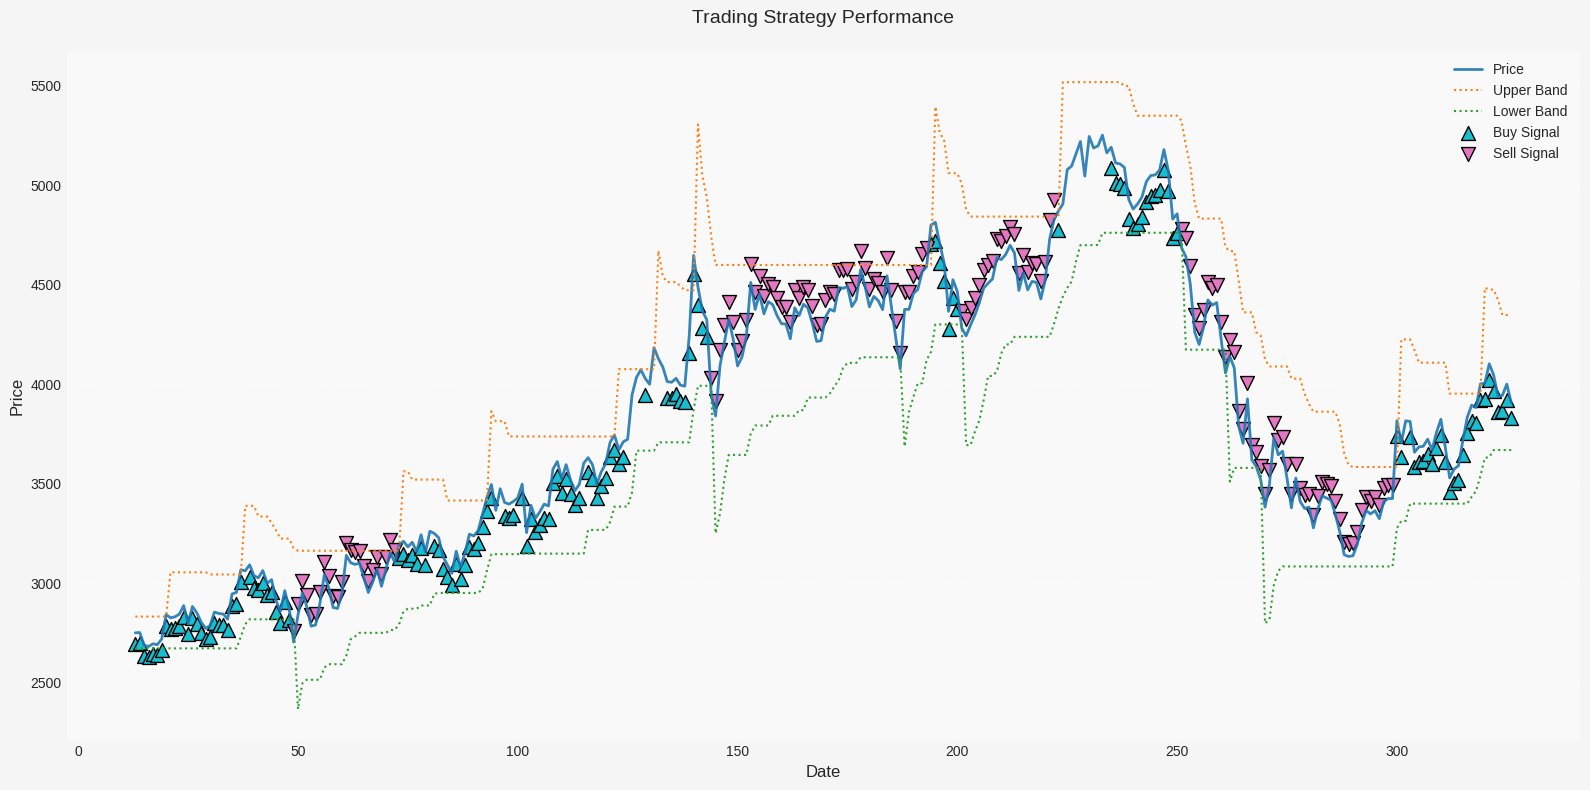

In [93]:
plt.figure(figsize=(16, 8), facecolor='#f5f5f5')

# Price and bands
plt.plot(df['close'], label='Price', color='#1f77b4', linewidth=2, alpha=0.9)
plt.plot(df['upperband'], label='Upper Band', color='#ff7f0e', linestyle=':', linewidth=1.5)
plt.plot(df['lowerband'], label='Lower Band', color='#2ca02c', linestyle=':', linewidth=1.5)

# Signals
plt.scatter(df[df['Signal'] == 1].index,
            df[df['Signal'] == 1]['close'] * 0.98,
            marker='^', color='#17becf', s=100, label='Buy Signal', edgecolors='black')
plt.scatter(df[df['Signal'] == -1].index,
            df[df['Signal'] == -1]['close'] * 1.02,
            marker='v', color='#e377c2', s=100, label='Sell Signal', edgecolors='black')

# Styling
plt.title('Trading Strategy Performance', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(framealpha=1, facecolor='white')

# Background and spines
ax = plt.gca()
ax.set_facecolor('#f9f9f9')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

**4. Incorporating a Complementary Indicator:**

<ipython-input-96-1641869602>:147: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

<ipython-input-96-1641869602>:152: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

<ipython-input-96-1641869602>:160: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



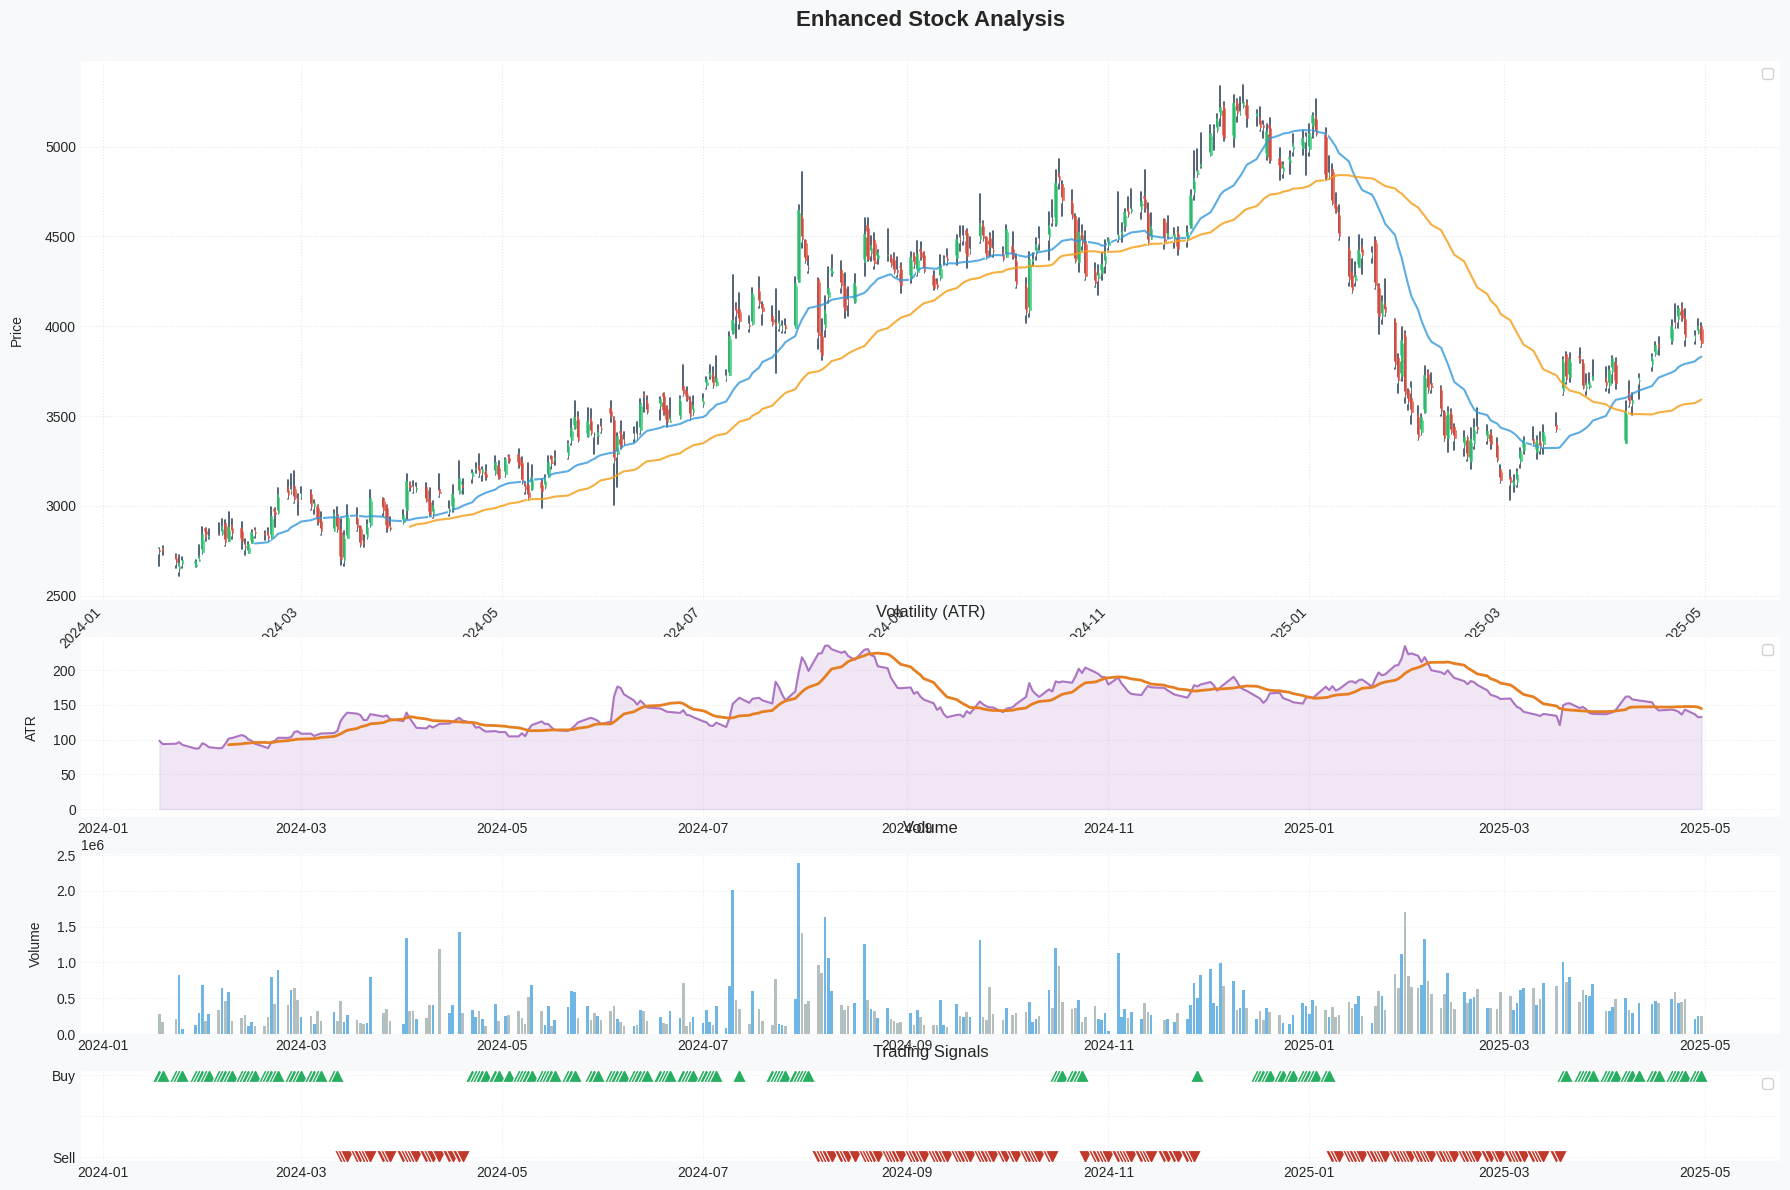

In [96]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def enhanced_stock_visualization(price_data, atr_window=14):
    fig = plt.figure(figsize=(18, 12), facecolor='#f8f9fa')
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 1, 1, 0.5])

    price_ax = fig.add_subplot(gs[0])
    price_ax.set_facecolor('#ffffff')
    atr_ax = fig.add_subplot(gs[1], sharex=price_ax)
    atr_ax.set_facecolor('#ffffff')
    vol_ax = fig.add_subplot(gs[2], sharex=price_ax)
    vol_ax.set_facecolor('#ffffff')
    sig_ax = fig.add_subplot(gs[3], sharex=price_ax)
    sig_ax.set_facecolor('#ffffff')

    colors = {
        'bullish': '#2ecc71',
        'bearish': '#e74c3c',
        'wick': '#34495e',
        'atr': '#9b59b6',
        'atr_ma': '#e67e22',
        'volume_up': '#3498db',
        'volume_down': '#95a5a6',
        'buy_signal': '#27ae60',
        'sell_signal': '#c0392b'
    }

    for idx, candle in price_data.iterrows():
        is_bullish = candle['close'] >= candle['open']
        color = colors['bullish'] if is_bullish else colors['bearish']
        body_base = min(candle['open'], candle['close'])
        body_height = abs(candle['open'] - candle['close'])

        price_ax.add_patch(Rectangle(
            (mdates.date2num(candle['datetime'])-0.4, body_base),
            0.8, body_height,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,
            linewidth=0.5,
            zorder=2
        ))

        price_ax.plot(
            [mdates.date2num(candle['datetime'])]*2,
            [candle['low'], candle['high']],
            color=colors['wick'],
            linewidth=1.2,
            solid_capstyle='round',
            zorder=1
        )

        price_ax.plot(
            mdates.date2num(candle['datetime'])-0.4,
            candle['open'] if is_bullish else candle['close'],
            '|',
            color='white',
            markersize=4,
            markeredgewidth=0.8,
            zorder=3
        )
        price_ax.plot(
            mdates.date2num(candle['datetime'])+0.4,
            candle['close'] if is_bullish else candle['open'],
            '|',
            color='white',
            markersize=4,
            markeredgewidth=0.8,
            zorder=3
        )

    atr_ax.fill_between(
        price_data['datetime'],
        price_data['atr'],
        color=colors['atr'],
        alpha=0.15
    )
    atr_ax.plot(
        price_data['datetime'],
        price_data['atr'],
        color=colors['atr'],
        linewidth=1.5,
        alpha=0.8
    )
    atr_ax.plot(
        price_data['datetime'],
        price_data['atr_ma'],
        color=colors['atr_ma'],
        linewidth=2
    )

    vol_ax.bar(
        price_data['datetime'],
        price_data['volume'],
        color=[colors['volume_up'] if x['close'] >= x['open'] else colors['volume_down'] for _, x in price_data.iterrows()],
        width=0.8,
        alpha=0.7
    )

    if 'Signal' in price_data.columns:
        buy_signals = price_data[price_data['Signal'] == 1]
        sell_signals = price_data[price_data['Signal'] == -1]

        sig_ax.scatter(
            buy_signals['datetime'],
            [1]*len(buy_signals),
            marker='^',
            color=colors['buy_signal'],
            s=100,
            edgecolors='white',
            linewidths=0.8,
            zorder=3
        )
        sig_ax.scatter(
            sell_signals['datetime'],
            [-1]*len(sell_signals),
            marker='v',
            color=colors['sell_signal'],
            s=100,
            edgecolors='white',
            linewidths=0.8,
            zorder=3
        )
        sig_ax.set_yticks([-1, 0, 1])
        sig_ax.set_yticklabels(['Sell', '', 'Buy'])

    price_ax.plot(
        price_data['datetime'],
        price_data['close'].rolling(20).mean(),
        color='#3498db',
        linewidth=1.5,
        alpha=0.8
    )
    price_ax.plot(
        price_data['datetime'],
        price_data['close'].rolling(50).mean(),
        color='#f39c12',
        linewidth=1.5,
        alpha=0.8
    )

    price_ax.set_title('Enhanced Stock Analysis', pad=25, fontsize=16, fontweight='bold')
    price_ax.set_ylabel('Price', labelpad=15)
    price_ax.grid(True, linestyle=':', color='#dddddd', alpha=0.7)
    price_ax.legend(frameon=True, facecolor='white', framealpha=0.9)

    atr_ax.set_title('Volatility (ATR)', pad=15, fontsize=12)
    atr_ax.set_ylabel('ATR', labelpad=10)
    atr_ax.grid(True, linestyle=':', color='#dddddd', alpha=0.5)
    atr_ax.legend(frameon=True, facecolor='white', framealpha=0.9)

    vol_ax.set_title('Volume', pad=15, fontsize=12)
    vol_ax.set_ylabel('Volume', labelpad=10)
    vol_ax.grid(True, linestyle=':', color='#dddddd', alpha=0.5)

    if 'Signal' in price_data.columns:
        sig_ax.set_title('Trading Signals', pad=10, fontsize=12)
        sig_ax.legend(frameon=True, facecolor='white', framealpha=0.9)
        sig_ax.grid(True, linestyle=':', color='#dddddd', alpha=0.5)

    plt.setp(price_ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15)
    plt.show()

if 'atr' not in df.columns:
    df['atr'] = calculate_atr(df)
if 'atr_ma' not in df.columns:
    df['atr_ma'] = df['atr'].rolling(14).mean()

enhanced_stock_visualization(df)

Strategy Y Performance:
Total Return: -49.37%
Success Rate: 43.80%
Total Trades: 137


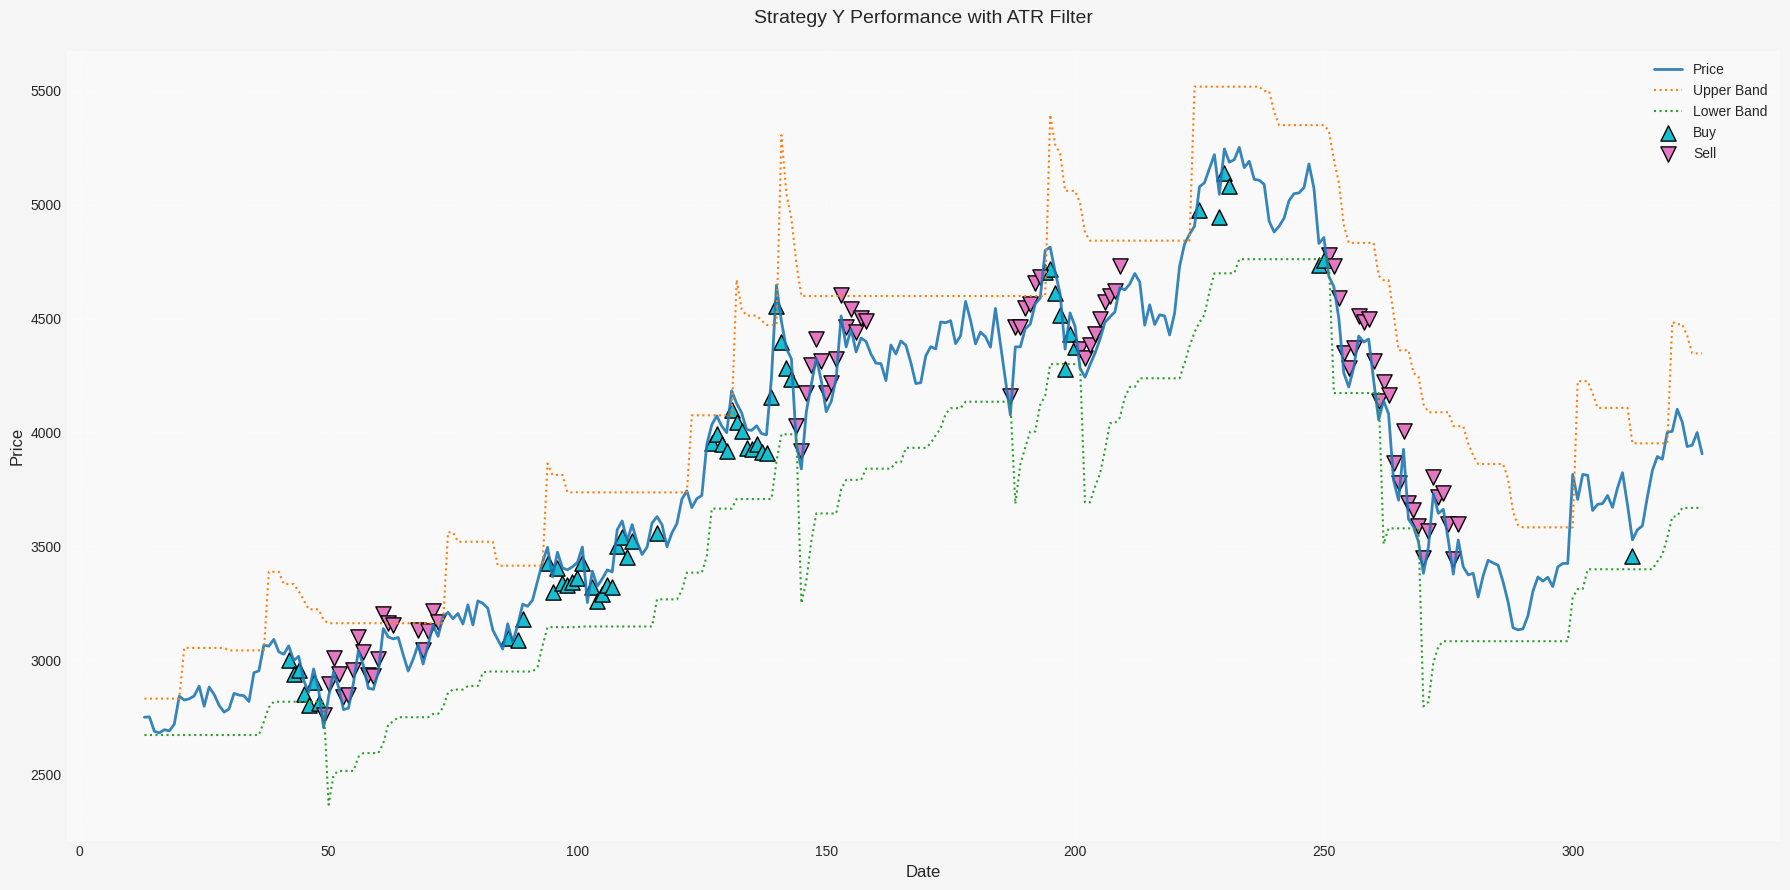

In [97]:
# Strategy Y Implementation with ATR Filter
def execute_strategy_y(price_data):
    price_data['Position'] = 0
    price_data.loc[(price_data['supertrend'] == 1) & (price_data['MFI'] < 80), 'Position'] = 1
    price_data.loc[(price_data['supertrend'] == -1) & (price_data['MFI'] > 20), 'Position'] = -1

    price_data['Position'] = np.where(price_data['atr'] > price_data['atr_ma'], price_data['Position'], 0)

    price_data['Daily_Return'] = price_data['close'].pct_change()
    price_data['Strategy_PnL'] = price_data['Position'].shift(1) * price_data['Daily_Return']

    total_pnl = price_data['Strategy_PnL'].sum() * 100
    winning_trades = price_data[price_data['Strategy_PnL'] > 0].shape[0]
    total_trades = price_data[price_data['Strategy_PnL'] != 0].shape[0]
    success_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    print(f"Strategy Y Performance:")
    print(f"Total Return: {total_pnl:.2f}%")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Total Trades: {total_trades}")

    return price_data

# Enhanced Visualization
def visualize_strategy_performance(price_data):
    plt.figure(figsize=(18, 9), facecolor='#f5f5f5')

    plt.plot(price_data['close'], label='Price', color='#1f77b4', linewidth=2, alpha=0.9)
    plt.plot(price_data['upperband'], label='Upper Band', color='#ff7f0e', linestyle=':', linewidth=1.5)
    plt.plot(price_data['lowerband'], label='Lower Band', color='#2ca02c', linestyle=':', linewidth=1.5)

    buy_signals = price_data[price_data['Position'] == 1]
    sell_signals = price_data[price_data['Position'] == -1]

    plt.scatter(buy_signals.index,
                buy_signals['close'] * 0.98,
                marker='^', color='#17becf', s=120,
                label='Buy', edgecolors='black', linewidth=1)

    plt.scatter(sell_signals.index,
                sell_signals['close'] * 1.02,
                marker='v', color='#e377c2', s=120,
                label='Sell', edgecolors='black', linewidth=1)

    plt.title('Strategy Y Performance with ATR Filter', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(framealpha=1, facecolor='white')

    ax = plt.gca()
    ax.set_facecolor('#f9f9f9')
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

# Execute Strategy Y
df['atr_ma'] = df['atr'].rolling(30).mean()
df = execute_strategy_y(df)

# Visualize Results
visualize_strategy_performance(df)

5. Strategy Enhancements:

To improve robustness, it's essential to recognize specific market conditions—such as range-bound, erratic, or low-liquidity environments—where the current strategy may falter or generate misleading signals.

Challenges:

In sideways or erratic markets, Supertrend often produces false trend reversals, while MFI can misrepresent momentum due to indecisive price action.

During low-volume phases, MFI loses its reliability, reducing the effectiveness of signals based on buying/selling pressure.

Suggested Improvements:

Incorporate a volatility screen using ATR: Avoid initiating trades when the ATR value is below a threshold, as it typically indicates a stagnant or non-trending market, where breakouts are less reliable.

Introduce a trend alignment filter using EMA-200: Execute long positions only when the price is above the 200-period EMA, and short positions when it’s below.